In [1]:
# !pip install statsmodels

In [59]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
all_data_df = pd.read_csv('Data.csv')
sample_df = pd.read_csv('SampleSubmission.csv')

In [3]:
len(sample_df)

6014

In [4]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN


In [5]:
sample_df.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0


# Preprocess

In [6]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1


In [7]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

In [8]:
# Filter the DataFrame to include only rows where 'consumer_device' is in the 'devices_to_drop' list.
filtered_df = all_data_df[all_data_df['consumer_device'].isin(devices_to_drop)]

# Now 'filtered_df' contains only the rows you specified.  You can further process or save this DataFrame.
filtered_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
327816,2023-10-01 14:35:00,169.26,3.50,0.73,0.036038,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327817,2023-10-01 14:40:00,169.20,3.15,0.76,0.033755,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327818,2023-10-01 14:45:00,168.38,2.58,0.73,0.026427,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327819,2023-10-01 14:50:00,168.87,2.52,0.76,0.026952,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327820,2023-10-01 14:55:00,168.30,2.47,0.75,0.025981,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1


In [9]:
# for all_data["Source"] aggregate by sum on day

import pandas as pd
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'], as_index=False)['kwh'].sum()

merged_df = all_data_df.drop(columns=['kwh']).merge(aggregated_data, on=['Source', 'Date'], how='left')

# Display the aggregated data
merged_df

,date_time,v_red,current,power_factor,Source,v_blue,v_yellow,consumer_device,data_user,Date,kwh
0,2024-07-22 18:20:00,137.65,0.08,0.72,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1,2024-07-22,0.02433
1,2024-07-22 18:25:00,122.82,0.08,0.73,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1,2024-07-22,0.02433
2,2024-07-22 18:30:00,119.70,0.08,0.74,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1,2024-07-22,0.02433
3,2024-07-22 18:35:00,124.53,0.08,0.75,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1,2024-07-22,0.02433
4,2024-07-22 18:40:00,134.84,0.08,0.74,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1,2024-07-22,0.02433
...,...,...,...,...,...,...,...,...,...,...,...
17140908,2024-02-06 22:55:00,NaN,0.00,0.00,consumer_device_25_data_user_3,NaN,0.0,consumer_device_25,3,2024-02-06,0.00000
17140909,2024-02-06 23:00:00,NaN,0.00,0.00,consumer_device_25_data_user_3,NaN,0.0,consumer_device_25,3,2024-02-06,0.00000
17140910,2024-02-06 23:05:00,NaN,0.00,0.00,consumer_device_25_data_user_3,NaN,0.0,consumer_device_25,3,2024-02-06,0.00000
17140911,2024-02-06 23:10:00,NaN,0.00,0.00,consumer_device_25_data_user_3,NaN,0.0,consumer_device_25,3,2024-02-06,0.00000


In [10]:
agg_df = all_data_df.groupby(['Source', 'Date', 'consumer_device'], as_index=False).agg({
    'kwh': 'sum',
    # 'power_factor': 'mean',
    # 'current': 'mean',
})
agg_df

,Source,Date,consumer_device,kwh
0,consumer_device_10_data_user_1,2024-07-22,consumer_device_10,0.024330
1,consumer_device_10_data_user_1,2024-07-23,consumer_device_10,0.103560
2,consumer_device_10_data_user_1,2024-07-24,consumer_device_10,0.137543
3,consumer_device_10_data_user_1,2024-07-25,consumer_device_10,0.121011
4,consumer_device_10_data_user_1,2024-07-26,consumer_device_10,0.000000
...,...,...,...,...
59723,consumer_device_25_data_user_3,2024-02-02,consumer_device_25,0.000000
59724,consumer_device_25_data_user_3,2024-02-03,consumer_device_25,0.000000
59725,consumer_device_25_data_user_3,2024-02-04,consumer_device_25,0.000000
59726,consumer_device_25_data_user_3,2024-02-05,consumer_device_25,0.000000


In [11]:
agg_df['Date'].nunique()

458

In [18]:
climate_df = pd.read_excel('Climate Data/Kalam Climate Data.xlsx')
climate_df                 

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2023-06-03 13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.000000,99.972656
1,2023-06-03 14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.000000,99.972656
2,2023-06-03 15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.000000,99.972656
3,2023-06-03 16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.000000,99.972656
4,2023-06-03 17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.000000,99.972656
...,...,...,...,...,...,...,...,...
12223,2024-10-24 20:00:00,-5.387305,-5.942435,0.045059,-1.108795,0.000394,0.000129,7.855469
12224,2024-10-24 21:00:00,-6.008307,-6.837256,0.015198,-1.194077,0.000395,0.000129,7.859375
12225,2024-10-24 22:00:00,-6.535742,-7.863989,-0.028015,-1.230438,0.000397,0.000129,7.863281
12226,2024-10-24 23:00:00,-6.864859,-8.328970,-0.058334,-1.272537,0.000399,0.000130,7.871094


In [19]:
climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])
climate_df['Date'] = climate_df['Date Time'].dt.date
climate_df.drop(columns=['Date Time'], inplace=True)
climate_df = climate_df.groupby(climate_df['Date']).mean().reset_index()

In [23]:
combined_columns = list(set(agg_df.columns) | set(climate_df.columns))
combined_columns

['U Wind Component (m/s)',
 'Source',
 'Total Precipitation (mm)',
 'Date',
 'V Wind Component (m/s)',
 'Dewpoint Temperature (°C)',
 'kwh',
 'consumer_device',
 'Snowfall (mm)',
 'Temperature (°C)',
 'Snow Cover (%)']

In [41]:
# full_df = pd.DataFrame(columns=combined_columns)

# for _, row1 in agg_df.iterrows():
#     row2 = climate_df[climate_df['Date'] == row1['Date']].drop(columns=['Date']).iloc[0]
#     comb_row = pd.concat([row1, row2], axis=0)
#     full_df.loc[len(full_df)] = comb_row

# full_df

,U Wind Component (m/s),Source,Total Precipitation (mm),Date,V Wind Component (m/s),Dewpoint Temperature (°C),kwh,consumer_device,Snowfall (mm),Temperature (°C),Snow Cover (%)
0,0.022655,consumer_device_10_data_user_1,0.003044,2024-07-22,-0.104998,8.280669,0.02433,consumer_device_10,0.0,14.719596,0.0
1,0.116137,consumer_device_10_data_user_1,0.00508,2024-07-23,-0.077997,9.8627,0.10356,consumer_device_10,0.0,13.217268,0.0
2,0.103451,consumer_device_10_data_user_1,0.004999,2024-07-24,-0.075028,9.865658,0.137543,consumer_device_10,0.0,12.46219,0.0
3,0.066345,consumer_device_10_data_user_1,0.001428,2024-07-25,-0.043182,8.973798,0.121011,consumer_device_10,0.0,13.867551,0.0
4,0.093025,consumer_device_10_data_user_1,0.00029,2024-07-26,0.046414,9.434734,0.0,consumer_device_10,0.0,15.572609,0.0
...,...,...,...,...,...,...,...,...,...,...,...
59723,-0.026519,consumer_device_25_data_user_3,0.000107,2024-02-02,-0.865386,-26.809788,0.0,consumer_device_25,0.000106,-15.93958,99.972656
59724,0.016363,consumer_device_25_data_user_3,0.006204,2024-02-03,-0.441434,-15.839776,0.0,consumer_device_25,0.006202,-12.9442,99.972656
59725,0.010035,consumer_device_25_data_user_3,0.003614,2024-02-04,-0.585848,-17.107609,0.0,consumer_device_25,0.003612,-13.131192,99.972656
59726,0.021365,consumer_device_25_data_user_3,0.000159,2024-02-05,-0.825506,-22.670691,0.0,consumer_device_25,0.000158,-15.237657,99.972656


In [42]:
# full_df.to_csv('full.csv', index=False)
full_df = pd.read_csv('full.csv')

# Training

In [45]:
# agg_df = agg_df.sort_values('Date')
full_df = full_df.sort_values('Date')
copy_df = full_df.copy()
split_index = int(len(full_df) * 0.8)

In [ ]:
copy_df['Date'] = pd.to_datetime(copy_df['Date'])

copy_df['year'] = copy_df['Date'].dt.year
copy_df['month'] = copy_df['Date'].dt.month
copy_df['day'] = copy_df['Date'].dt.day

copy_df.drop(columns=['Date'], inplace=True)

In [126]:
copy_df.drop(columns=['consumer_device'], inplace=True)

In [127]:
# train_data = copy_df[:split_index]
# valid_data = copy_df[split_index:]
# x_train = train_data.drop(columns=['kwh'])
# y_train = train_data['kwh']
# x_valid = valid_data.drop(columns=['kwh'])
# y_valid = valid_data['kwh']
x = copy_df.drop(columns=['kwh'])
y = copy_df['kwh']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [128]:
from catboost import CatBoostRegressor, Pool

cb_params = {
    'iterations': 5000,
    'learning_rate': 1e-2,
    'loss_function': 'RMSE',
    # 'eval_metric': 'AUC',
    # 'depth': 2,
    # 'l2_leaf_reg': 5,
    # 'bagging_temperature': 3,
    # 'random_strength': 0.005,
    # 'border_count': 64,
    # 'od_type': 'IncToDec',
    'verbose': 100,
    # 'subsample': 1.0,
    # 'random_seed': 42,
    'early_stopping_rounds': 1000,
    'task_type': 'CPU',
}

In [131]:
# cat_features = ['Source', 'consumer_device']
cat_features = ['Source']

In [132]:
train_pool = Pool(x_train, y_train, cat_features=cat_features)
valid_pool = Pool(x_valid, y_valid, cat_features=cat_features)

In [133]:
cb_model = CatBoostRegressor(**cb_params)

cb_model.fit(train_pool, eval_set=[train_pool, valid_pool], use_best_model=True)

0:	learn: 3.8768940	test: 3.8768940	test1: 4.0997601	best: 4.0997601 (0)	total: 35.8ms	remaining: 2m 58s
100:	learn: 3.5977550	test: 3.5876182	test1: 3.7910676	best: 3.7910676 (100)	total: 1.41s	remaining: 1m 8s
200:	learn: 3.5232024	test: 3.5112797	test1: 3.7121093	best: 3.7121093 (200)	total: 2.93s	remaining: 1m 10s
300:	learn: 3.4806468	test: 3.4718246	test1: 3.6679894	best: 3.6679894 (300)	total: 4.17s	remaining: 1m 5s
400:	learn: 3.4449930	test: 3.4365348	test1: 3.6290680	best: 3.6290680 (400)	total: 5.47s	remaining: 1m 2s
500:	learn: 3.4171953	test: 3.4135204	test1: 3.6018243	best: 3.6018243 (500)	total: 6.54s	remaining: 58.7s
600:	learn: 3.3921916	test: 3.3922435	test1: 3.5779016	best: 3.5779016 (600)	total: 7.45s	remaining: 54.6s
700:	learn: 3.3703025	test: 3.3754141	test1: 3.5621490	best: 3.5621490 (700)	total: 8.83s	remaining: 54.1s
800:	learn: 3.3478787	test: 3.3572663	test1: 3.5416136	best: 3.5416136 (800)	total: 10.1s	remaining: 53s
900:	learn: 3.3245424	test: 3.3371551	te

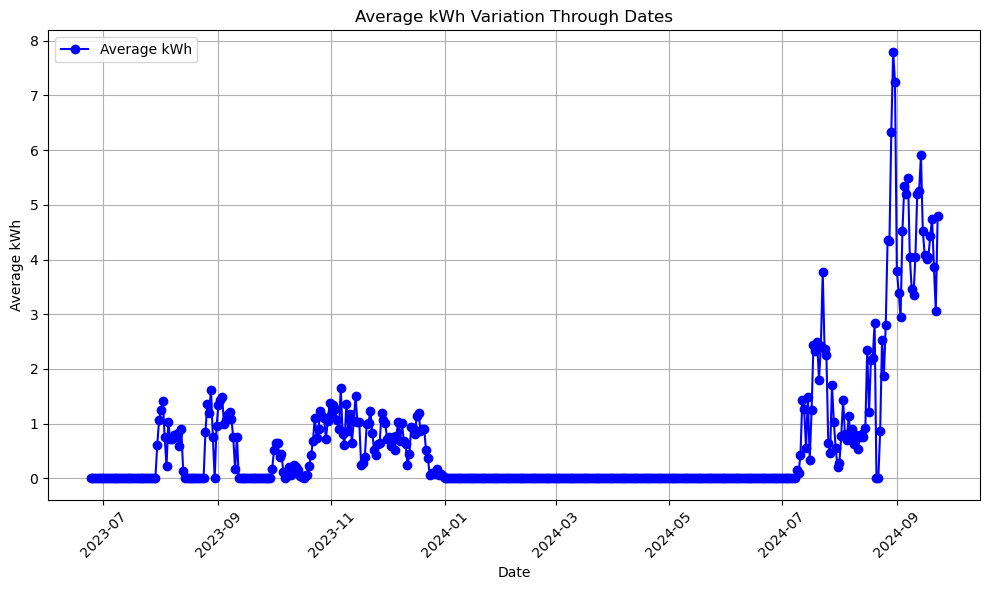

In [57]:
df_grouped = full_df.groupby('Date')['kwh'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Date'], df_grouped['kwh'], marker='o', linestyle='-', color='b', label='Average kWh')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Average kWh')
plt.title('Average kWh Variation Through Dates')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [134]:
valid_preds = cb_model.predict(x_valid)
np.sqrt(mean_squared_error(y_valid, valid_preds))

3.2064132921119612

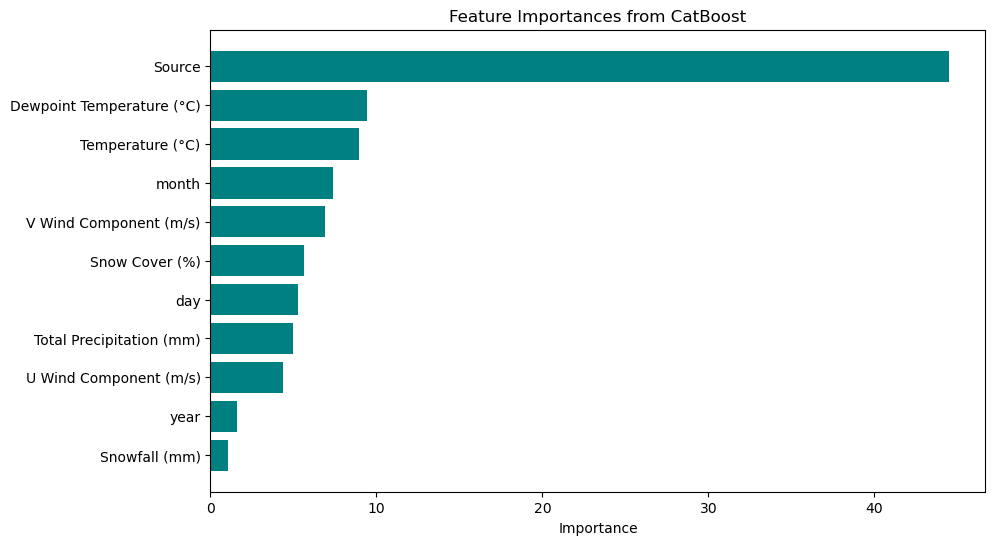

In [135]:
feature_importances = cb_model.get_feature_importance()

feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importances from CatBoost')
plt.show()

# Inference

In [71]:
sample_df

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0
6010,2024-10-21_consumer_device_8_data_user_9,0
6011,2024-10-22_consumer_device_8_data_user_9,0
6012,2024-10-23_consumer_device_8_data_user_9,0


In [111]:
test_df = sample_df.copy()
test_df[['Date', 'Source']] = test_df['ID'].str.split('_', n=1, expand=True)[[0, 1]]
test_df['Date'] = pd.to_datetime(test_df['Date']).dt.date
test_df['consumer_device'] = test_df['Source'].str.split('_').str[:3].str.join('_')
test_df

,ID,kwh,Date,Source,consumer_device
0,2024-09-24_consumer_device_12_data_user_1,0,2024-09-24,consumer_device_12_data_user_1,consumer_device_12
1,2024-09-25_consumer_device_12_data_user_1,0,2024-09-25,consumer_device_12_data_user_1,consumer_device_12
2,2024-09-26_consumer_device_12_data_user_1,0,2024-09-26,consumer_device_12_data_user_1,consumer_device_12
3,2024-09-27_consumer_device_12_data_user_1,0,2024-09-27,consumer_device_12_data_user_1,consumer_device_12
4,2024-09-28_consumer_device_12_data_user_1,0,2024-09-28,consumer_device_12_data_user_1,consumer_device_12
...,...,...,...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0,2024-10-20,consumer_device_8_data_user_9,consumer_device_8
6010,2024-10-21_consumer_device_8_data_user_9,0,2024-10-21,consumer_device_8_data_user_9,consumer_device_8
6011,2024-10-22_consumer_device_8_data_user_9,0,2024-10-22,consumer_device_8_data_user_9,consumer_device_8
6012,2024-10-23_consumer_device_8_data_user_9,0,2024-10-23,consumer_device_8_data_user_9,consumer_device_8


In [112]:
full_test_df = pd.DataFrame(columns=combined_columns)

for _, row1 in test_df.iterrows():
    row2 = climate_df[climate_df['Date'] == row1['Date']].drop(columns=['Date']).iloc[0]
    comb_row = pd.concat([row1, row2], axis=0)
    full_test_df.loc[len(full_test_df)] = comb_row

full_test_df

,U Wind Component (m/s),Source,Total Precipitation (mm),Date,V Wind Component (m/s),Dewpoint Temperature (°C),kwh,consumer_device,Snowfall (mm),Temperature (°C),Snow Cover (%)
0,0.005811,consumer_device_12_data_user_1,0.000001,2024-09-24,-0.264604,2.104299,0,consumer_device_12,0.0,13.899341,0.0
1,0.22428,consumer_device_12_data_user_1,0.000158,2024-09-25,0.183461,5.623678,0,consumer_device_12,0.0,12.475849,0.0
2,0.202651,consumer_device_12_data_user_1,0.005112,2024-09-26,0.044908,7.37516,0,consumer_device_12,0.0,9.702699,0.0
3,0.042285,consumer_device_12_data_user_1,0.018497,2024-09-27,0.168467,5.905107,0,consumer_device_12,0.000827,6.806661,3.789225
4,-0.042425,consumer_device_12_data_user_1,0.002479,2024-09-28,0.149797,2.932036,0,consumer_device_12,0.000053,6.399286,4.174235
...,...,...,...,...,...,...,...,...,...,...,...
6009,0.046748,consumer_device_8_data_user_9,0.000153,2024-10-20,-0.296137,-4.460602,0,consumer_device_8,0.0,3.693599,2.13859
6010,-0.118125,consumer_device_8_data_user_9,0.000356,2024-10-21,-0.373651,-3.217974,0,consumer_device_8,0.0,3.712101,1.033285
6011,0.047106,consumer_device_8_data_user_9,0.000432,2024-10-22,-0.21438,-2.358298,0,consumer_device_8,0.000007,2.515382,0.531738
6012,0.001728,consumer_device_8_data_user_9,0.00235,2024-10-23,-0.2276,-0.711822,0,consumer_device_8,0.001129,0.315618,6.653727


In [113]:
full_test_df['Date'] = pd.to_datetime(full_test_df['Date'])
full_test_df['year'] = full_test_df['Date'].dt.year
full_test_df['month'] = full_test_df['Date'].dt.month
full_test_df['day'] = full_test_df['Date'].dt.day
full_test_df.drop(columns=['Date'], inplace=True)

In [116]:
full_test_df.drop(columns=['kwh'])

,U Wind Component (m/s),Source,Total Precipitation (mm),V Wind Component (m/s),Dewpoint Temperature (°C),consumer_device,Snowfall (mm),Temperature (°C),Snow Cover (%),year,month,day
0,0.005811,consumer_device_12_data_user_1,0.000001,-0.264604,2.104299,consumer_device_12,0.0,13.899341,0.0,2024,9,24
1,0.22428,consumer_device_12_data_user_1,0.000158,0.183461,5.623678,consumer_device_12,0.0,12.475849,0.0,2024,9,25
2,0.202651,consumer_device_12_data_user_1,0.005112,0.044908,7.37516,consumer_device_12,0.0,9.702699,0.0,2024,9,26
3,0.042285,consumer_device_12_data_user_1,0.018497,0.168467,5.905107,consumer_device_12,0.000827,6.806661,3.789225,2024,9,27
4,-0.042425,consumer_device_12_data_user_1,0.002479,0.149797,2.932036,consumer_device_12,0.000053,6.399286,4.174235,2024,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...
6009,0.046748,consumer_device_8_data_user_9,0.000153,-0.296137,-4.460602,consumer_device_8,0.0,3.693599,2.13859,2024,10,20
6010,-0.118125,consumer_device_8_data_user_9,0.000356,-0.373651,-3.217974,consumer_device_8,0.0,3.712101,1.033285,2024,10,21
6011,0.047106,consumer_device_8_data_user_9,0.000432,-0.21438,-2.358298,consumer_device_8,0.000007,2.515382,0.531738,2024,10,22
6012,0.001728,consumer_device_8_data_user_9,0.00235,-0.2276,-0.711822,consumer_device_8,0.001129,0.315618,6.653727,2024,10,23


In [125]:
np.sort(full_df['consumer_device'].unique()), np.sort(full_test_df['consumer_device'].unique())

(array(['consumer_device_1', 'consumer_device_10', 'consumer_device_11',
        'consumer_device_12', 'consumer_device_13', 'consumer_device_14',
        'consumer_device_15', 'consumer_device_16', 'consumer_device_17',
        'consumer_device_18', 'consumer_device_19', 'consumer_device_20',
        'consumer_device_21', 'consumer_device_22', 'consumer_device_23',
        'consumer_device_24', 'consumer_device_25'], dtype=object),
 array(['consumer_device_12', 'consumer_device_13', 'consumer_device_16',
        'consumer_device_18', 'consumer_device_2', 'consumer_device_21',
        'consumer_device_22', 'consumer_device_23', 'consumer_device_26',
        'consumer_device_29', 'consumer_device_31', 'consumer_device_32',
        'consumer_device_35', 'consumer_device_36', 'consumer_device_37',
        'consumer_device_8'], dtype=object))

In [120]:
np.setdiff1d(full_test_df['consumer_device'].unique(), full_df['consumer_device'].unique())

array(['consumer_device_2', 'consumer_device_26', 'consumer_device_29',
       'consumer_device_31', 'consumer_device_32', 'consumer_device_35',
       'consumer_device_36', 'consumer_device_37', 'consumer_device_8'],
      dtype=object)

In [138]:
test_preds = cb_model.predict(full_test_df.drop(columns=['kwh', 'consumer_device']))
test_preds

array([1.22722603, 2.04710784, 2.56515395, ..., 9.21240071, 8.3788532 ,
       7.3641762 ])

In [139]:
sub_df = sample_df.copy()
sub_df['kwh'] = test_preds
sub_df

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,1.227226
1,2024-09-25_consumer_device_12_data_user_1,2.047108
2,2024-09-26_consumer_device_12_data_user_1,2.565154
3,2024-09-27_consumer_device_12_data_user_1,1.777471
4,2024-09-28_consumer_device_12_data_user_1,1.110765
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,7.666601
6010,2024-10-21_consumer_device_8_data_user_9,7.863826
6011,2024-10-22_consumer_device_8_data_user_9,9.212401
6012,2024-10-23_consumer_device_8_data_user_9,8.378853


In [140]:
sub_df.to_csv('hydro_sub.csv', index=False)